# Clean for visualizations

The point of this notebooks is to take the updated crime data every Monday and then run this to generate the associated files (csv, json) that are then fed into viz software like datawrapper to update the live vizs. 

After running this notebook, every data file related to a viz should have updated. It will have it's own .yml file.

In [28]:
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calplot
import json
import os
import re

pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_colwidth", None) 

In [2]:
crimes = pd.read_csv("bart_crime_updated.csv")
crimes.head()

,description,incident_num,location,agency,date,time
0,DRUG EQUIPMENT VIOLATIONS,2510-0416,2000 BLOCK Mission St,BART Police,10-7-2025,2:08 PM
1,DRUG/NARCOTIC VIOLATIONS,2510-0174,2000 BLOCK Mission St,BART Police,10-3-2025,12:35 PM
2,ALL OTHER LARCENY,2510-0208,2000 BLOCK Mission St,BART Police,10-3-2025,9:40 AM
3,DRUG/NARCOTIC VIOLATIONS,2510-0129,2000 BLOCK Mission St,BART Police,10-2-2025,6:39 PM
4,FALSE PRETENSE/SWINDLE/CONFIDENCE GAME,2510-0032,2000 BLOCK Mission St,BART Police,10-1-2025,1:16 PM


### Clean data

In [3]:
crimes['description'] = crimes['description'].str.lower().str.strip()

crimes['location'] = crimes['location'].str.lower().str.strip()

crimes['incident_num'] = crimes['incident_num'].str.strip()

crimes['agency'] = crimes['agency'].str.lower().str.strip()

crimes['date'] = crimes['date'].str.strip()
crimes['time'] = crimes['time'].str.strip()

crimes['date'] = pd.to_datetime(crimes['date'], format='%m-%d-%Y')
crimes['month_year'] = crimes['date'].dt.strftime('%b %Y')

crimes = crimes.sort_values('date', ascending=False).reset_index(drop=True)

In [4]:
crimes.head()

,description,incident_num,location,agency,date,time,month_year
0,drug equipment violations,2511-0262,2000 block mission st,bart police,2025-11-05,9:57 AM,Nov 2025
1,simple assault,2510-1447,2000 block mission st,bart police,2025-10-23,6:14 PM,Oct 2025
2,intimidation,2510-1179,2000 block mission st,bart police,2025-10-19,10:57 PM,Oct 2025
3,drug equipment violations,2510-1028,2000 block mission st,bart police,2025-10-17,8:03 AM,Oct 2025
4,simple assault,2510-0983,2000 block mission st,bart police,2025-10-16,3:34 PM,Oct 2025


### Graphs 

1. per month all crimes
2. Broken down small multiples column chart 

In [6]:
descriptions_df = crimes["description"].value_counts().reset_index()
descriptions_df.columns = ['description', 'count']

In [7]:
by_month = crimes["month_year"].value_counts().reset_index()
by_month.columns = ['time', 'count']

In [ ]:
stacked_data = pd.crosstab(
    crimes_sorted['month_year'], 
    crimes_sorted['description_grouped']
)

# Reorder chronologically
month_order = crimes_sorted.groupby('month_year')['month_year_dt'].first().sort_values().index
stacked_data = stacked_data.loc[month_order]

# Reset index to make month_year a column
stacked_data = stacked_data.reset_index()

In [8]:
descriptions_df.to_csv("viz/bart/crime_desc.csv", index = False)
by_month.to_csv("viz/bart/crime_time.csv", index = False)
stacked_data.to_csv('viz/bart/crimes_stacked.csv', index=False)

## Trial graphic

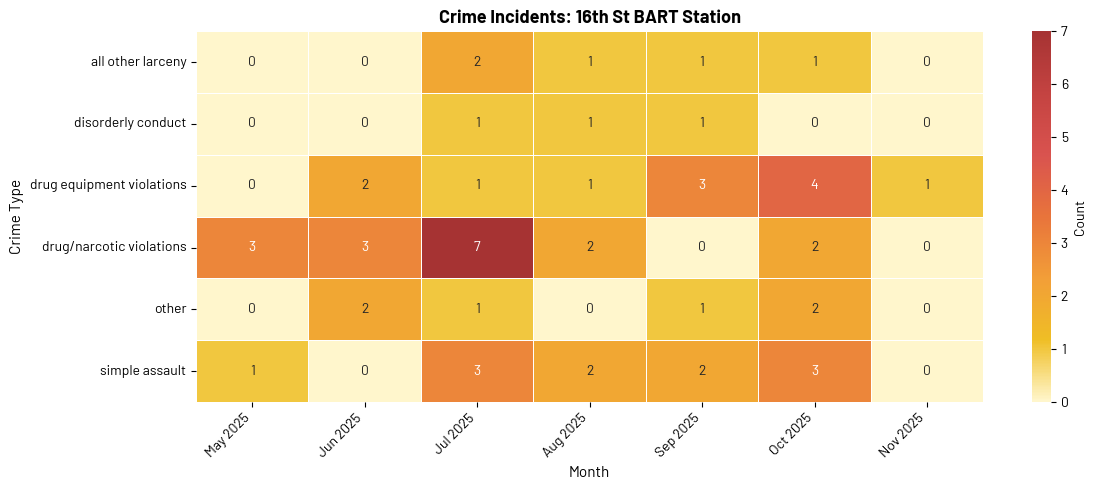

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap

# Create directory if it doesn't exist
os.makedirs('viz/bart', exist_ok=True)

# Create custom colormap with your colors
colors = ['#fff6cc', '#efbe25', '#f29e38', '#e8743b', '#d9534f', '#c44341', '#a63333']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Fix month ordering - convert to datetime and sort
crimes['month_year_dt'] = pd.to_datetime(crimes['month_year'], format='%b %Y')
crimes_sorted = crimes.sort_values('month_year_dt')

# Group rare crimes into "other"
crime_counts = crimes['description'].value_counts()
top_crimes = crime_counts[crime_counts >= 3].index
crimes_sorted['description_grouped'] = crimes_sorted['description'].apply(
    lambda x: x if x in top_crimes else 'other'
)

# Create crosstab with sorted data
heatmap_data = pd.crosstab(
    crimes_sorted['description_grouped'], 
    crimes_sorted['month_year']
)

# Reorder columns chronologically
month_order = crimes_sorted.groupby('month_year')['month_year_dt'].first().sort_values().index
heatmap_data = heatmap_data[month_order]

# Create heatmap - 1200x900 pixels at 100 dpi = 12x9 inches
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap=custom_cmap, cbar_kws={'label': 'Count'}, linewidths=0.5, ax=ax)

# Set Barlow font for all text elements
ax.set_xlabel('Month', fontsize=11, fontfamily='Barlow')
ax.set_ylabel('Crime Type', fontsize=11, fontfamily='Barlow')
ax.set_title('Crime Incidents: 16th St BART Station', fontsize=13, fontweight='bold', fontfamily='Barlow')

# Set Barlow for tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily('Barlow')

# Set Barlow for colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Count', fontfamily='Barlow')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('viz/bart/crime_heatmap.png', dpi=100, bbox_inches='tight')
plt.show()

## Calendar Map JSON

In [31]:
# Group by date and get crime types for each day
calendar_export = crimes.groupby('date').agg({
    'description': lambda x: list(x),
    'incident_num': 'count'
}).reset_index()

calendar_export['date'] = calendar_export['date'].dt.strftime('%Y-%m-%d')
calendar_export = calendar_export.rename(columns={'incident_num': 'count', 'description': 'types'})

# Convert to list of dictionaries
calendar_data = calendar_export.to_dict('records')

# Save as JSON
with open('viz/bart/calendar/calendar_data.json', 'w') as f:
    json.dump(calendar_data, f, indent=2)

print(f"Saved {len(calendar_data)} days of data")

Saved 42 days of data
